In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

## Task 1: Hand-Crafted Network
### Task 1.1: Neuron Definition
First, we create a Neuron class taking a bias, list of weights, and activation function as a base.
To demonstrate its functionality, we use the weighted average as default activation function, and run it with a simple test case.

In [2]:
class Neuron:

    def weighted_avg(values, params):
        return np.mean(values * params)
    
    def __init__(self, bias=0.0, params=list(), afunc=weighted_avg):
        self.bias = bias
        self.params = np.asarray(params)
        self.afunc = afunc
    
    def activate(self, inputs):
        return self.bias + self.afunc(inputs, self.params)

In [3]:
neuron = Neuron(bias=0.5, params=[0.1, 0.2, 0.3])
assert neuron.activate([3, 2, 1]) == 0.5 + (3 * 0.1 + 2 * 0.2 + 1 * 0.3) / 3
print("weighted_avg of", [3, 2, 1], "with weights", neuron.params, "and bias", neuron.bias, "is", neuron.activate([3, 2, 1]))

weighted_avg of [3, 2, 1] with weights [0.1 0.2 0.3] and bias 0.5 is 0.8333333333333333


Next, we define our three activation functions <code>logical_or</code>, <code>masked_or</code>, and <code>xnor</code> ("Perfect match") to use in our neuron.
For <code>logical_or</code>, we only need the input data. For <code>masked_or</code> and <code>xnor</code>, we use the neuron parameters as bitmasks.

To verify our implementation, we run a few simple test cases.

In [4]:
def logical_or(values, params):
    return values.any()

def masked_or(values, params):
    return np.logical_and(values, params).any()

def xnor(values, params):
    return not np.logical_xor(values, params).any()

In [5]:
list1 = np.array([0, 0, 0])
list2 = np.array([0, 0, 1])
list3 = np.array([0, 1, 1])

assert logical_or(list1, list()) == 0
print("logical_or on", list1, "is", logical_or(list1, list()))
assert logical_or(list2, list()) == 1
print("logical_or on", list2, "is", logical_or(list2, list()))
assert logical_or(list3, list()) == 1
print("logical_or on", list3, "is", logical_or(list3, list()))

assert masked_or(list2, list1) == 0
print("masked_or on", list2, "with mask", list1, "is", masked_or(list2, list1))
assert masked_or(list2, list3) == 1
print("masked_or on", list2, "with mask", list3, "is", masked_or(list2, list3))

assert xnor(list2, list3) == 0
print("xnor on", list2, "and", list1, "is", xnor(list2, list3))
assert xnor(list3, list3) == 1
print("xnor on", list3, "and", list3, "is", xnor(list3, list3))

logical_or on [0 0 0] is False
logical_or on [0 0 1] is True
logical_or on [0 1 1] is True
masked_or on [0 0 1] with mask [0 0 0] is False
masked_or on [0 0 1] with mask [0 1 1] is True
xnor on [0 0 1] and [0 0 0] is False
xnor on [0 1 1] and [0 1 1] is True


To turn these activation functions into proper neurons, we now have to create a couple of neurons using these methods.
To demonstrate their functionality, we will run the same test cases on these neurons.
For these simple cases, the bias is always zero, and the output is only determined by the input (And the mask supplied through the <code>params</code> attribute).

In [6]:
or_neuron = Neuron(afunc=logical_or)
assert or_neuron.activate(list1) == 0
print("logical_or neuron on", list1, "is", or_neuron.activate(list1))
assert or_neuron.activate(list2) == 1
print("logical_or neuron on", list2, "is", or_neuron.activate(list2))
assert or_neuron.activate(list3) == 1
print("logical_or neuron on", list3, "is", or_neuron.activate(list3))

masked_neuron_list1 = Neuron(params=list1, afunc=masked_or)
masked_neuron_list3 = Neuron(params=list3, afunc=masked_or)
assert masked_neuron_list1.activate(list2) == 0
print("masked_or neuron on", list2, "with mask", list1, "is", masked_neuron_list1.activate(list2))
assert masked_neuron_list3.activate(list2) == 1
print("masked_or neuron on", list2, "with mask", list3, "is", masked_neuron_list3.activate(list2))

xnor_neuron = Neuron(params=list3, afunc=xnor)
assert xnor_neuron.activate(list2) == 0
print("xnor neuron on", list2, "and", list1, "is", xnor_neuron.activate(list2))
assert xnor_neuron.activate(list3) == 1
print("xnor neuron on", list3, "and", list3, "is", xnor_neuron.activate(list3))

logical_or neuron on [0 0 0] is 0.0
logical_or neuron on [0 0 1] is 1.0
logical_or neuron on [0 1 1] is 1.0
masked_or neuron on [0 0 1] with mask [0 0 0] is 0.0
masked_or neuron on [0 0 1] with mask [0 1 1] is 1.0
xnor neuron on [0 0 1] and [0 0 0] is 0.0
xnor neuron on [0 1 1] and [0 1 1] is 1.0


### Task 1.2: Network Creation
The easiest way to model a hypercube of dimension <code>M</code> within one layer of neural network is to create one neuron per dimension, and using the neuron output (0 or 1) as coordinates in their respective dimension.
To achieve that, every neuron in the first layer has to stricly map to a certain region of the input parameter space, ideally covering the entire parameter space.
One solution would be to define a triangle region for each parameter using three line equations defined by <code>m</code> (Slope of the line), <code>t</code> (Offset from zero), and <code>s</code> (Sign of the inequality to differentiate between the two sides of the line).

In [7]:
def are_coords_in_triangle(coords, triangles):
    match = list()

    for i in range(3):
        above = triangles[3 * i + 2]
        line = lambda x: triangles[3 * i] * x + triangles[3 * i + 1]

        if above:
            match.append(coords[1] > line(coords[0]))
        else:
            match.append(coords[1] <= line(coords[0]))

    return np.all(match)

To test the implementation of the triangle function, we use a simple test case of f<sub>1</sub>(x)= 0, f<sub>2</sub>(x)= x+0, and f<sub>3</sub>(x)= -x+2, which should generate a triangle with corners (0, 0), (1, 1), and (2, 0).
As shown by the coloring of the three corners, points exactly on the edges of the triangle are only considered to be inside the triangle if the line they're on is defined with <code>s = False<

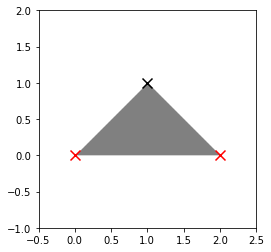

In [8]:
triangle = [0, 0, True, 1, 0, False, -1, 2, False]

grid_x, grid_y = np.meshgrid(np.linspace(-0.5, 2.5, 300), np.linspace(-1, 2, 300))
grid_points = np.stack([grid_x.ravel(), grid_y.ravel()], axis=1)
grid_image = [are_coords_in_triangle(coords, triangle) for coords in grid_points]

plt.imshow(np.reshape(grid_image, (300, 300)), extent=[-0.5, 2.5, -1, 2], origin="lower", cmap="binary", alpha=0.5)
plt.scatter(0, 0, marker='x', s=100, color="black" if are_coords_in_triangle((0, 0), triangle) else "red")
plt.scatter(1, 1, marker='x', s=100, color="black" if are_coords_in_triangle((1, 1), triangle) else "red")
plt.scatter(2, 0, marker='x', s=100, color="black" if are_coords_in_triangle((2, 0), triangle) else "red")
plt.show()

Next, we have to determine the decision boundaries for the sample data given by tiling the feature space.
To simplify the process, the feature space will have a range of \[0, 1\].

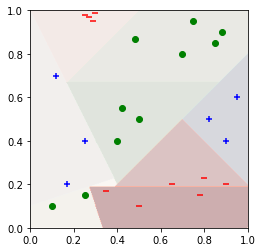

In [9]:
points = [
    [0.1, 0.1, "green", "o"],
    [0.25, 0.15, "green", "o"],
    [0.17, 0.2, "blue", "+"],
    [0.25, 0.4, "blue", "+"],
    [0.12, 0.7, "blue", "+"],
    [0.25, 0.98, "red", "_"],
    [0.27, 0.97, "red", "_"],
    [0.29, 0.95, "red", "_"],
    [0.3, 0.99, "red", "_"],
    [0.4, 0.4, "green", "o"],
    [0.5, 0.5, "green", "o"],
    [0.42, 0.55, "green", "o"],
    [0.48, 0.87, "green", "o"],
    [0.7, 0.8, "green", "o"],
    [0.75, 0.95, "green", "o"],
    [0.85, 0.85, "green", "o"],
    [0.88, 0.9, "green", "o"],
    [0.35, 0.17, "red", "_"],
    [0.5, 0.1, "red", "_"],
    [0.65, 0.2, "red", "_"],
    [0.8, 0.23, "red", "_"],
    [0.9, 0.2, "red", "_"],
    [0.78, 0.15, "red", "_"],
    [0.82, 0.5, "blue", "+"],
    [0.9, 0.4, "blue", "+"],
    [0.95, 0.6, "blue", "+"],
]

tiles = list()
labels = list()

labels.append("Green")
tiles.append([0.0, 0.0, True, 0.33, 0.1, False, -3.0, 1.0, False])
labels.append("Blue")
tiles.append([0.33, 0.1, True, -999, 1.0, True, -2.0, 1.0, False])
labels.append("Red")
tiles.append([-2.0, 1.0, True, 0.0, 1.0, False, 1.0, 0.5, True])
labels.append("Green")
tiles.append([1.0, 0.5, False, 0.0, 0.67, True, 1.0, -0.2, True])
labels.append("Green")
tiles.append([-2.0, 1.0, True, 0.0, 0.67, False, 1.0, -0.2, True])
labels.append("Blue")
tiles.append([1.0, -0.2, False, -1.0, 1.2, True, 999, -999, True])
labels.append("Red")
tiles.append([-1.0, 1.2, False, 1.0, -0.2, False, 0.0, 0.19, True])
labels.append("Red")
tiles.append([-3.0, 1.0, True, 0.0, 0.19, False, 999, -999, True])

for tile, label in zip(tiles, labels):
    grid_x, grid_y = np.meshgrid(np.linspace(0, 1, 300), np.linspace(0, 1, 300))
    grid_points = np.stack([grid_x.ravel(), grid_y.ravel()], axis=1)
    grid_image = [are_coords_in_triangle(coords, tile) for coords in grid_points]

    plt.imshow(np.reshape(grid_image, (300, 300)), extent=[0, 1, 0, 1], cmap=label + "s",
               origin="lower", vmin=0, vmax=1, alpha=0.3)

for point in points:
    plt.scatter(point[0], point[1], color=point[2], marker=point[3])

plt.show()

With these regions in place, we can now turn them into our first layer of the neural network, and use the previously created binary neurons to build our second layer, and create our prediction function.

In [10]:
first_layer = [Neuron(afunc=are_coords_in_triangle, params=tile) for tile in tiles]

red_neuron = Neuron(afunc=masked_or, params=[label == "Red" for label in labels])
green_neuron = Neuron(afunc=masked_or, params=[label == "Green" for label in labels])
blue_neuron = Neuron(afunc=masked_or, params=[label == "Blue" for label in labels])
second_layer = [red_neuron, green_neuron, blue_neuron]

layers = [first_layer, second_layer]

def predict_nn(data, layers):
    for layer in layers:
        data = [neuron.activate(data) for neuron in layer]
    return data

The network should be able to recreate the labels and decision regions without any errors, meaning we should be able to recreate the previous plot using the network's predictions for coloring alone, and correctly predict the label of every training instance.

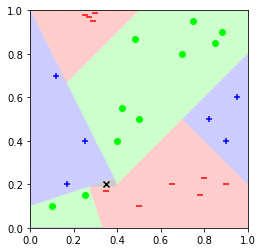

In [15]:
res = 300

def rgba(rgb, a):
    return [rgb[0], rgb[1], rgb[2], a]

def label_to_marker(label):
    if label == [1.0, 0.0, 0.0]:
        return "_"
    elif label == [0.0, 1.0, 0.0]:
        return "o"
    elif label == [0.0, 0.0, 1.0]:
        return "+"
    else:
        return "x"

grid_x, grid_y = np.meshgrid(np.linspace(0, 1, res), np.linspace(0, 1, res))
grid_points = np.stack([grid_x.ravel(), grid_y.ravel()], axis=1)
grid_image = [rgba(predict_nn(coords, layers), 0.2) for coords in grid_points]

plt.imshow(np.reshape(grid_image, (res, res, 4)), extent=[0, 1, 0, 1],
           origin="lower", vmin=0, vmax=1)

for point in points:
    label = predict_nn(point[0:2], layers)
    plt.scatter(point[0], point[1], color=label, marker=label_to_marker(label))

label = predict_nn([0.35, 0.2], layers)
plt.scatter(0.35, 0.2, color=label, marker=label_to_marker(label))

plt.show()

As demonstrated, the network is perfectly capable of reproducing the labels of the training data and the decision regions without failure.
The only issue with the presented network is that it can be very challenging to cover the entire input parameter space with the chosen approach of tiling the space into triangles - The small region surrounding the coordinates (0.35, 0.2) (Marked with a black X on the plot), for example, does not have any neurons associated with it, resulting in a (0.0, 0.0, 0.0) prediction and a black shade in the plot.
### Task 1.3: Generalization for higher-dimensional input
The chosen approach heavily relies on the two-dimensionality of input data, as a higher-dimensional variant of the triangle tiling requires much more complex boundary planes instead of simple line equations, which makes it significantly harder to manually set them.

A similar, but easier approach could use n-dimensional spheres instead of triangles, then the generalization for higher-dimensional input would be a lot more manageable, and could even be automated for any training data (Which would effectively result in a nearest-neighbor-like algorithm), allowing the implementation to be much more useful.
Especially the automated implementation would yield a lot more input regions unassociated with any neurons in the first layer though, which would make it even more difficult to predict labels outside of the training set.

Similarly, more complex label distributions make it significantly harder to properly fit neurons onto the training set, which results in a higher total number of neurons, and a huge decrease in runtime, because every neuron in every layer has to execute its activation function for every input data point. With the current (Relatively simple) network, the prediction of the 90k data point used to generate the plot above already took several seconds - although a more streamlined implementation making use of NumPy's array functions could probably help out with this issue, especially with the n-sphere approach.